In [1]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler
import soundfile as sf
import random


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

model = DiffusionModel(
    net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
    in_channels=2, # U-Net: number of input/output (audio) channels
    channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024], # U-Net: channels at each layer
    factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
    items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
    attentions=[0, 0, 0, 0, 0, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
    attention_heads=8, # U-Net: number of attention heads per attention item
    attention_features=64, # U-Net: number of attention features per attention item
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler, # The diffusion sampler used
)



In [3]:
import torch.nn.functional as F
from torchaudio.transforms import PitchShift

In [4]:
import os
import numpy as np
import librosa
import soundfile as sf
import random

# Single function to augment the audio with time rolling and amplitude scaling
def augment_audio(file_path, n_augmentations, output_folder):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    augmented_files = []
    
    for i in range(n_augmentations):
        # Ensure the roll amount keeps the size the same (no loss in duration)
        roll_amount = random.randint(-len(audio)//10, len(audio)//10)  # Random roll within 10% of length
        
        # Time rolling (shift the audio)
        rolled_audio = np.roll(audio, roll_amount)

        # Amplitude scaling (apply random scaling factor)
        scale_factor = random.uniform(0.5, 2.0)  # Random scale factor between 0.5 and 2.0
        scaled_audio = rolled_audio * scale_factor

        # Ensure the size of the output is the same as the original
        scaled_audio = scaled_audio[:len(audio)]  # Truncate if necessary

        # Generate a unique name for the augmented file
        augmented_file_name = f'augmented_{os.path.basename(file_path).split(".")[0]}_{i+1}.wav'
        augmented_file_path = os.path.join(output_folder, augmented_file_name)
        
        # Save the augmented audio in the specified output folder
        sf.write(augmented_file_path, scaled_audio, sr)
        augmented_files.append(augmented_file_path)

    return augmented_files

# Example usage
files = audio_files = [
    "GW150914_template_stereo.wav",
    "GW151226_template_stereo.wav",
    "GW170104_template_stereo.wav",
    "LVT151012_template_stereo.wav"
]  # List of input files
n_augmentations = 20  # Number of augmented files per input file
output_folder = 'augmented_data'  # Folder to store augmented files

augmented_audio_files = []
for file in files:
    augmented_audio_files.extend(augment_audio(file, n_augmentations, output_folder))

print(f'Generated augmented files: {augmented_audio_files}')


Generated augmented files: ['augmented_data/augmented_GW150914_template_stereo_1.wav', 'augmented_data/augmented_GW150914_template_stereo_2.wav', 'augmented_data/augmented_GW150914_template_stereo_3.wav', 'augmented_data/augmented_GW150914_template_stereo_4.wav', 'augmented_data/augmented_GW150914_template_stereo_5.wav', 'augmented_data/augmented_GW150914_template_stereo_6.wav', 'augmented_data/augmented_GW150914_template_stereo_7.wav', 'augmented_data/augmented_GW150914_template_stereo_8.wav', 'augmented_data/augmented_GW150914_template_stereo_9.wav', 'augmented_data/augmented_GW150914_template_stereo_10.wav', 'augmented_data/augmented_GW150914_template_stereo_11.wav', 'augmented_data/augmented_GW150914_template_stereo_12.wav', 'augmented_data/augmented_GW150914_template_stereo_13.wav', 'augmented_data/augmented_GW150914_template_stereo_14.wav', 'augmented_data/augmented_GW150914_template_stereo_15.wav', 'augmented_data/augmented_GW150914_template_stereo_16.wav', 'augmented_data/augme

In [5]:
# change the directory to the augmented data
os.chdir('augmented_data')
# Define dataset class
class BlackHoleDataset(Dataset):
    def __init__(self, audio_files, sample_rate=16000, audio_length=2**18):
        self.audio_files = audio_files
        self.sample_rate = sample_rate
        self.audio_length = audio_length
        
        # Extract labels from filenames (e.g., "GW150914_template_shifted.wav" → "GW150914")
        self.labels = [os.path.basename(f).split('_')[0] for f in audio_files]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        waveform, sr = torchaudio.load(audio_path)  # Load audio

        # Resample if needed
        if sr != self.sample_rate:
            resampler = T.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)
        
        # Ensure fixed length (pad/cut)
        if waveform.shape[1] > self.audio_length:
            waveform = waveform[:, :self.audio_length]  # Trim
        else:
            pad = self.audio_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad))  # Pad
        
        text_label = self.labels[idx]  # Extract text label (e.g., "GW150914")
        return waveform, text_label




In [6]:
audio_files = [
    "GW150914_template_stereo.wav",
    "GW151226_template_stereo.wav",
    "GW170104_template_stereo.wav",
    "LVT151012_template_stereo.wav"
]
total_files = np.concatenate([audio_files, augmented_audio_files])
dataset = BlackHoleDataset(total_files) 
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)



print(f"Total samples in dataset: {len(dataset)}")  

Total samples in dataset: 84


In [7]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):  
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Wrap the dataloader with tqdm for progress tracking
    progress_bar = tqdm(dataloader, desc=f"Training Epoch {epoch+1}", leave=True)
    
    for audio_wave, text_labels in progress_bar:
        audio_wave = audio_wave.to(device)  # Move to GPU if available
        
        loss = model(
            audio_wave
        )
        loss.backward()  # Compute gradients
        
        # Update tqdm progress bar with loss
        progress_bar.set_postfix(loss=loss.item())

print("Training complete! 🎉")

Epoch 1/10


Training Epoch 1:   0%|          | 0/84 [00:00<?, ?it/s]


LibsndfileError: Error opening np.str_('augmented_data/augmented_GW170104_template_stereo_11.wav'): System error.

In [ ]:
filename = "GW150914_H1_shifted.wav"
noise_sig = torchaudio.load(filename)[0].to(device)
# make the noise signal into a duplicated stereo signal
noise_signal = torch.cat([noise_sig, noise_sig], dim=0)
noise_signal = noise_signal[:, :2**18]  # Trim to fixed length
noise_signal = noise_signal / torch.max(torch.abs(noise_signal))  # Normalize
noise_signal = noise_signal.unsqueeze(0)  # Add batch dimension

generated_sample = model.sample(
    noise_signal,
    num_steps=100
).detach().cpu().numpy()

# Save the generated audio

sf.write("generated_blackhole.wav", generated_sample[0, 0], samplerate=16000)


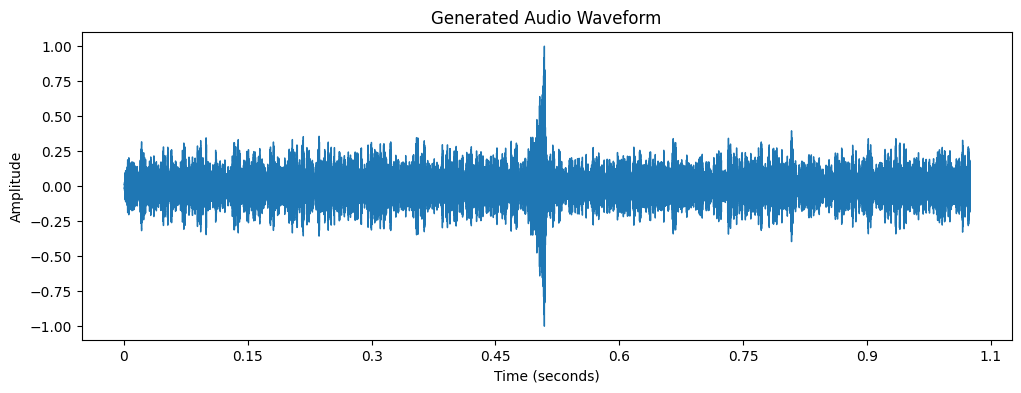

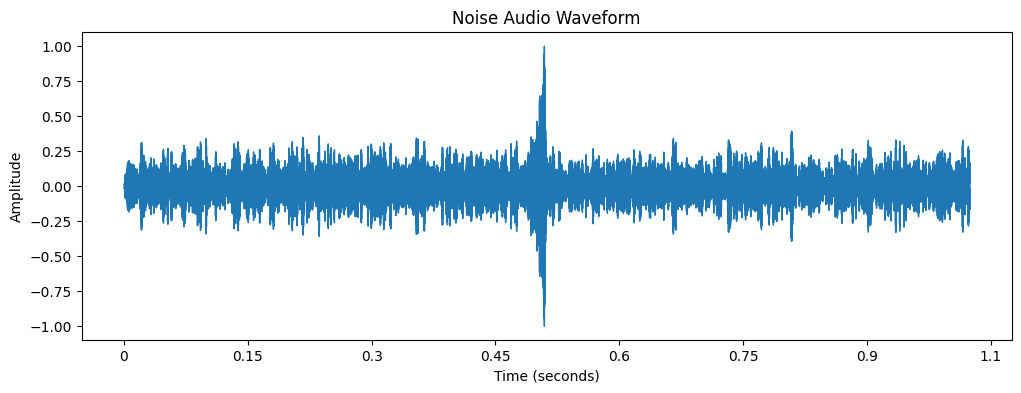

In [ ]:
# extract a single channel for visualization
audio_waveform = generated_sample[0, 0]  # take first batch, first channel

# normalize audio for playback
audio_waveform = audio_waveform / np.max(np.abs(audio_waveform))

# plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_waveform, sr=16000)  # assume 16kHz sample rate
plt.title("Generated Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()
# plot a vizualisation of the noise signal
noise_waveform = np.array(noise_signal[0, 0])  # take first batch, first channel


# plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(noise_waveform, sr=16000)  # assume 16kHz sample rate
plt.title("Noise Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

